In [1]:
import pandas as pd
import numpy as np
import ast
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def concatenate_reviews(data, isPreprocessed=True):
    corpus = []
    if (isPreprocessed):
        reviews = data['review'].copy()
        reviews = reviews.apply(ast.literal_eval)
        concatenated_reviews = reviews.apply(' '.join)
        concatenated_reviews.apply(corpus.append)
    else:
        corpus = data['review'].str.cat(sep=' ')
        
    return corpus

def graph_word_cloud(corpus):
    word_cloud = WordCloud(width=1600, height=800, collocations=False).generate(corpus)
    plt.figure(figsize=(20,20))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
def stem_review(review):
    stemmer = PorterStemmer()
    stemmed_review = [stemmer.stem(token) for token in review]
    return stemmed_review
  
def stem_reviews(data):
    data_copy = data.copy()
    data_copy['review'] = data_copy['review'].apply(ast.literal_eval)
    data_copy['review'] = data_copy['review'].apply(stem_review)
    data_copy['review'] = data_copy['review'].apply(str)
    return data_copy

def frequencies(corpus, vocab):
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    vectorizer = CountVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    word_frequencies = X.toarray().sum(axis=0)
    cv_results = dict(zip(words, word_frequencies))
    return cv_results

def tfidf_weights(corpus, vocab):  
    vocab_dict = {vocab[i]: i for i in range(len(vocab))}
    vectorizer = TfidfVectorizer(vocabulary=vocab)
    X = vectorizer.fit_transform(corpus)

    words = vectorizer.get_feature_names()
    inverse_document_frequency = vectorizer.idf_
    tf_idf_results = dict(zip(words, inverse_document_frequency))
    return tf_idf_results

def frequency_series(category, frequencies):
    frequencies = pd.Series(data=frequencies, name='frequency')
    frequencies.index.name = category
    frequencies.reset_index()
    return frequencies

In [3]:
data = pd.read_csv('data/review_data.csv')
preprocessed_data = pd.read_csv('data/preprocessed_review_data.csv')

In [4]:
# data exploration
print("Columns: {0}\n".format(preprocessed_data.columns.values))
print("Total reviews: {0}\n\n".format(preprocessed_data.shape[0]))
print("Was recommended:{0}\n".format(preprocessed_data['voted_up'].value_counts()))

containsDuplicates = preprocessed_data['steam_id'].duplicated().any()
print("Contains duplicate Steam IDs: {0}".format(containsDuplicates))

Columns: ['steam_id' 'review' 'timestamp_created' 'voted_up']

Total reviews: 28636


Was recommended:True     27574
False     1062
Name: voted_up, dtype: int64

Contains duplicate Steam IDs: False


In [ ]:
corpus = concatenate_reviews(data, isPreprocessed=False)
preprocessed_corpus = concatenate_reviews(preprocessed_data)

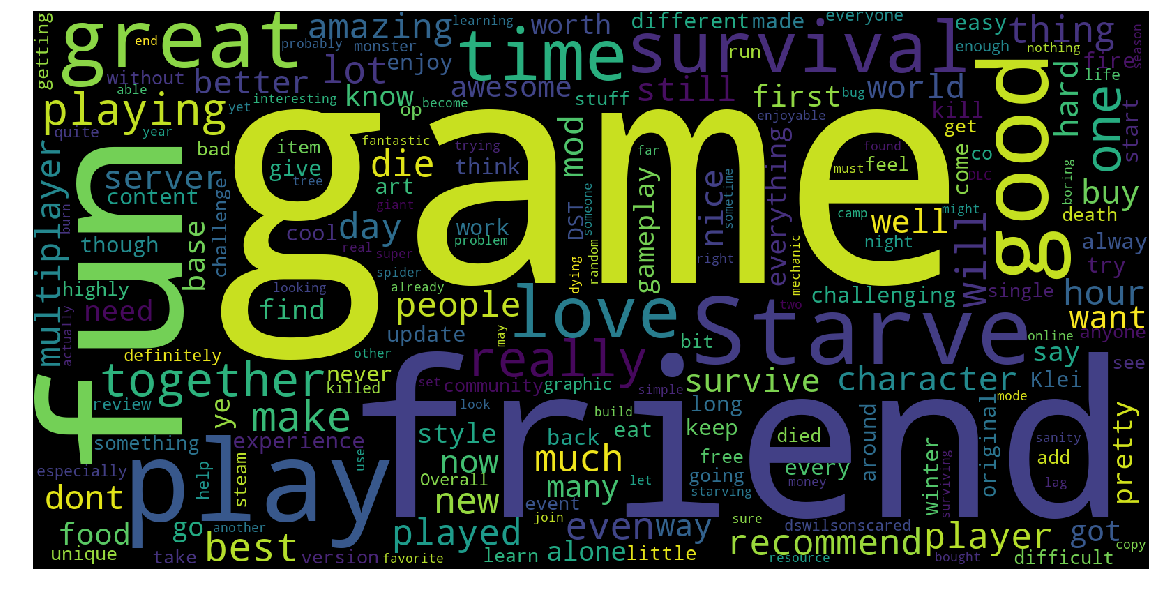

In [ ]:
# wordcloud without preprocessing
graph_word_cloud(corpus)

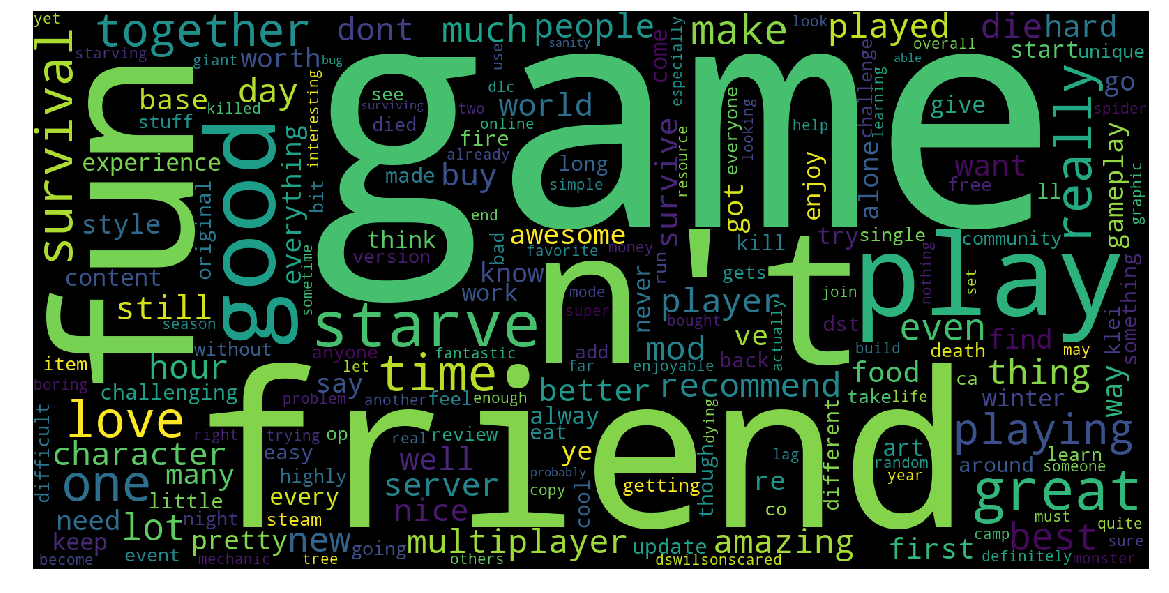

In [ ]:
# wordcloud with preprocessing
graph_word_cloud(' '.join(preprocessed_corpus))

In [ ]:
# calculate frequency and tf-idf weights for characters
characters = ["wilson", "willow", "wolfgang", "wendy", 
              "wx", "wickerbottom", "woodie", "wes", 
              "maxwell", "wigfrid", "webber", "warly", 
              "wormwood", "winona", "wortox", "wurt"]

character_frequencies = frequencies(preprocessed_corpus, characters)
character_weights = tfidf_weights(preprocessed_corpus, characters)

In [ ]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
monsters = ["spiders", "hounds", "tentacles", "merms",  
            "bees", "frogs", "pigs", "beefalos", "rabbits",
            "beargers", "deerclops", "dragonfly"]
lemmatized_monsters = [lemmatizer.lemmatize(monster) for monster in monsters]
stemmed_monsters = [stemmer.stem(monster) for monster in monsters]
print("lemmatized:\n{0}\n".format(lemmatized_monsters))
print("stemmed:\n{0}".format(stemmed_monsters))

stemmed_data = stem_reviews(preprocessed_data)
stemmed_corpus = concatenate_reviews(stemmed_data)

monster_frequencies = frequencies(stemmed_corpus, stemmed_monsters)
monster_weights = tfidf_weights(stemmed_corpus, stemmed_monsters)

lemmatized:
['spider', 'hound', 'tentacle', 'merms', 'bee', 'frog', 'pig', 'beefalo', 'rabbit', 'beargers', 'deerclops', 'dragonfly']

stemmed:
['spider', 'hound', 'tentacl', 'merm', 'bee', 'frog', 'pig', 'beefalo', 'rabbit', 'bearger', 'deerclop', 'dragonfli']


PorterStemmer was used to normalize the preprocessed data as the WordNetLemmatizer does not correctly lemmatize words specific to Don't Starve Together.

In [ ]:
seasons = ["autumn", "winters", "springs", "summers"]
stemmed_seasons = [stemmer.stem(season) for season in seasons]

season_frequencies = frequencies(stemmed_corpus, stemmed_seasons)
season_weights = tfidf_weights(stemmed_corpus, stemmed_seasons)

In [ ]:
character_series = frequency_series("character", character_frequencies)
monster_series = frequency_series("monster", monster_frequencies)
season_series = frequency_series("season", season_frequencies)

In [ ]:
fig, axes = plt.subplots(ncols=3, 
                         figsize=(16, 4), 
                         squeeze=False)

fig.subplots_adjust(wspace=0.40)
axes = axes.flatten()
for axis in axes:
    plt.setp(axis.get_xticklabels(), rotation=30, ha="right")
    
character_barplot = sns.barplot(x=character_series.index, y=character_series.values, ax=axes[0])
character_barplot.set(title="Character Frequency", xlabel= "Character", ylabel="Frequency")

monster_barplot = sns.barplot(x=monster_series.index, y=monster_series.values, ax=axes[1])
monster_barplot.set(title="Monster Frequency", xlabel= "Monster", ylabel="Frequency")

season_barplot = sns.barplot(x=season_series.index, y=season_series.values, ax=axes[2])
season_barplot.set(title="Season Frequency", xlabel= "Season", ylabel="Frequency")
    
plt.show()

It is important to note that the barplot aspect ratios are NOT equal and may result in bias, affecting comparisons between different categories. On the other hand, the tf-idf weights are more suited for comparisons between words from different categories while also allowing for comparisons between words from the same category.

In [ ]:
print("TF-IDF results for characters, monsters and seasons:\n")
display(character_weights)
display(monster_weights)
display(season_weights)